In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import umap
%matplotlib inline
sns.set(style='white', rc={'figure.figsize':(12,8)})

import requests
import zipfile
import imageio

Sklearn $\ge$ 0.19 is necessary for the efficient implementation of tsne.

In [2]:
import sklearn.manifold  
sklearn.__version__

'0.19.0'

### Pull the data from the internet and write it to a file

The COIL20 data set is a set of 1440 greyscale images consisting of 20 objects under 72 different rotations spanning 360 degrees.  Each image is a 128x128 image which we treat as a single 16384 dimensional vector for the purposes computing distance between images.

This download only takes a few seconds on a good connction.

In [4]:
%%time
downloadData = False
if(downloadData):
    results = requests.get('http://www.cs.columbia.edu/CAVE/databases/SLAM_coil-20_coil-100/coil-20/coil-20-proc.zip')
    with open("coil20.zip", "wb") as code:
        code.write(results.content)

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 6.91 µs


### Read in from file and transform into a vector space

We add a filter to ensure that we only parse png files from our download zip.

In [5]:
import re
images_zip = zipfile.ZipFile('coil20.zip')
mylist = images_zip.namelist()
r = re.compile(".*\.png$")
filelist = list(filter(r.match, mylist))

Next we pull the object id's from the file names using pandas

In [6]:
%%time
feature_vectors = []
for filename in [images_zip.filename+'/'+file for file in filelist]:
    im = imageio.imread(filename)
    feature_vectors.append(im.flatten())

CPU times: user 39.4 s, sys: 1.22 s, total: 40.6 s
Wall time: 41.5 s


### Now we have our data in a list of vectors.  Let's extract the object id's from the files and cast to data frame (in case we want to explore things further)

Leaving the data as a numpy array improves the efficiency of both UMAP and t-SNE as such we will resist our usual urge to cast our data to a Pandas data.frame for imporoved ease of exploration.

In [7]:
labels = pd.Series(filelist).str.extract("obj([0-9]+)", expand=False)

In [11]:
#data = pd.DataFrame(feature_vectors, index=labels)
data = np.array(feature_vectors)
data.shape

(1440, 16384)

### Now let's use UMAP to embed these points into a two dimensional space.

In [ ]:
fit = umap.UMAP(n_neighbors=5, random_state=42, metric='euclidean')
%time u = fit.fit_transform(data)

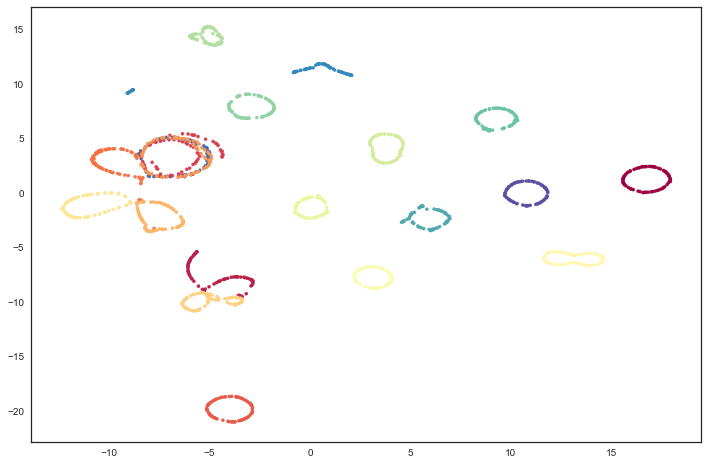

In [25]:
plt.scatter(u[:,0], u[:,1], c=labels, cmap="Spectral", s=10);

We'll make use of pandas for ease of file writing. 

In [13]:
output = pd.DataFrame(u, columns=('x','y'))
output['labels']=labels
output.to_csv('embedding_coil20_umap.csv')

We see here that UMAP manages to preserve much of the loop structure that is inherent within the coil data set. The coil data set was constructed by taking 20 objects and photographing them at various rotations.  These rotations are being reveiled by the locality preserving property of UMAP.

TO DO: Look at the global structure in between the groups

### T-SNE

In [15]:
fit_tsne = sklearn.manifold.TSNE()
%time u_tsne = fit_tsne.fit_transform(data)

CPU times: user 1min 14s, sys: 3.13 s, total: 1min 17s
Wall time: 1min 18s


In [16]:
output = pd.DataFrame(u_tsne, columns=('x','y'))
output['labels']=labels
output.to_csv('embedding_coil20_tsne.csv')

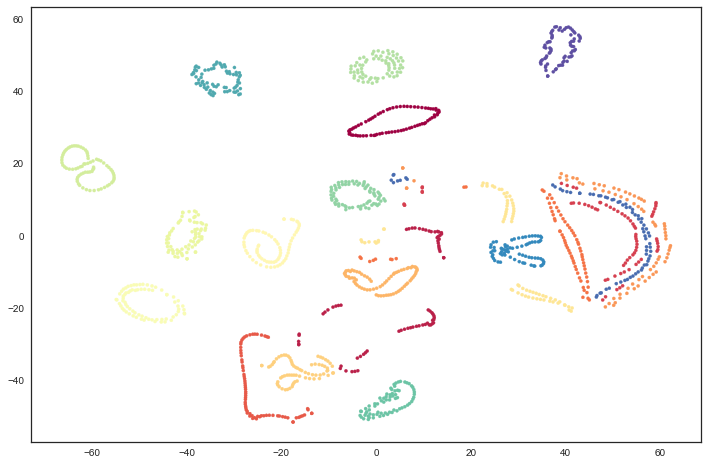

In [17]:
plt.scatter(u_tsne[:,0], u_tsne[:,1], c=labels, cmap="Spectral", s=10);

t-SNE breaks more of the loops losing some of the loop structure inherent in COIL.  On the other hand it does a very good job of seperating the objects within COIL.  It does this at the cost of breaking the loop structure ineherent within the COIL dataset.

TO DO: Examine the global positioning of COIL objects.

## MDS

For old times sake we attempt to embed with multi-dimensional scaling.  This is reasonable since the dataset in question is reasonably small.

In [18]:
fit_mds = sklearn.manifold.MDS()
%time u_mds = fit_mds.fit_transform(data)

CPU times: user 2min 17s, sys: 13.8 s, total: 2min 31s
Wall time: 1min 20s


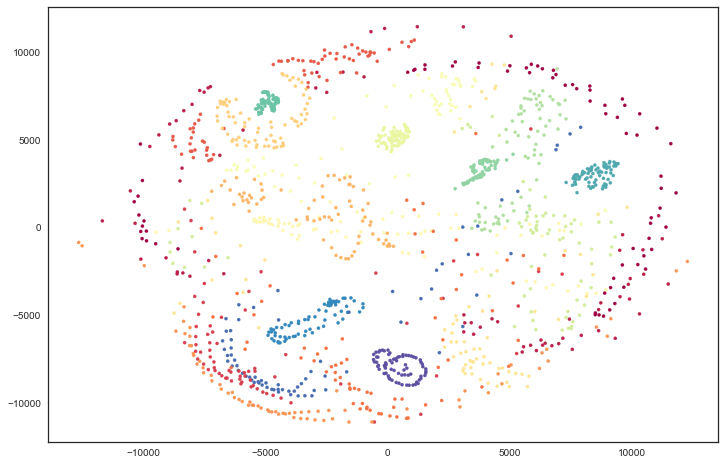

In [19]:
plt.scatter(u_mds[:,0], u_mds[:,1], c=labels, cmap="Spectral", s=10);

MDS and PCA (below) should do a better job preserving global structure at the expense of sacrificying local structure.  These can be seen in the loss of loop structure in our data and the dispersal of points across our space.

### PCA

The old standby of PCA which is blindingly fast to compute and often used as an initialization to many of the more complex algorithms.  This isn't really a competitor but instead should be thought of as a strawman.  Given that other algorithms initialize with these values one would hope that they can do better.

In [20]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
%time u_pca = pca.fit_transform(data)

CPU times: user 4.71 s, sys: 352 ms, total: 5.06 s
Wall time: 3.03 s


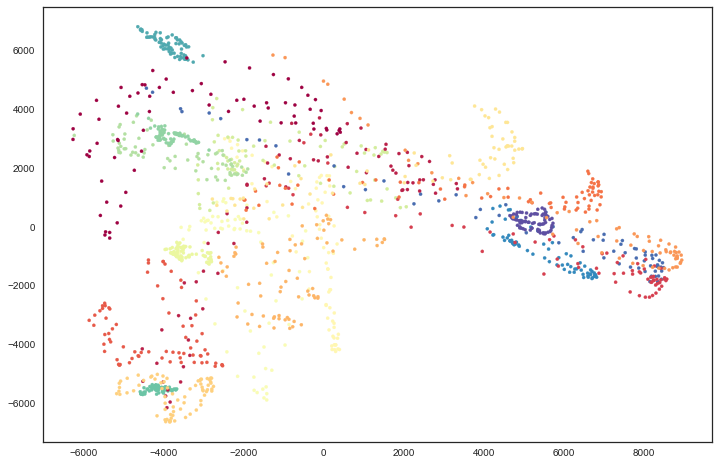

In [21]:
plt.scatter(u_pca[:,0], u_pca[:,1], c=labels, cmap="Spectral", s=10);

### ISOMAP 

Isomap should be to reveal some of the non-linear structure in our manifold where PCA and MDS had difficulties.

In [22]:
fit_isomap = sklearn.manifold.Isomap(n_neighbors=5)
%time u_isomap = fit_isomap.fit_transform(data)

CPU times: user 51.7 s, sys: 804 ms, total: 52.5 s
Wall time: 53.3 s


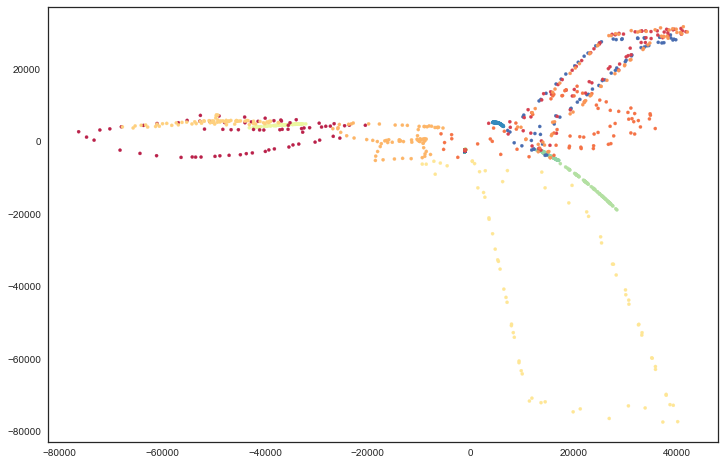

In [23]:
plt.scatter(u_isomap[:,0], u_isomap[:,1], c=labels, cmap="Spectral", s=10);

Isomap was able to identify some of the loop structure with COIL but is unable to separate the objects cleanly.  